# 1. Data Source & Overview

**Source:** Inside Airbnb (http://insideairbnb.com/) snapshot for New York City listings. We found the dataset from https://www.kaggle.com/datasets/ebrahimelgazar/new-york-city-airbnb-market/data
**Files:**  
- `airbnb_last_review.csv`: last review date per listing  
- `airbnb_price.csv`: nightly price and neighborhood  
- `airbnb_room_type.csv`: room description and type  

This data has been partially cleaned (no duplicate `listing_id`s), but columns like `price` still include “\$” and commas and will need further cleaning before analysis.

**Overall:**  
- **Listings:** 25,209  
- **Variables:**  
  - *Qualitative (categorical)*: `host_name`, `nbhood_full`, `room_type`  
  - *Quantitative (numeric)*: none yet (raw `price` is text)  
  - *Text*: `description`  
  - *Date*: `last_review`

In [41]:
import pandas as pd

# Read last_review, parsing the date column
last_review = pd.read_csv('airbnb_last_review.csv', parse_dates=['last_review'])
# Read nightly price data
price = pd.read_csv('airbnb_price.csv')
# Read room description and type
room_type = pd.read_csv('airbnb_room_type.csv')

# Inspect each DataFrame’s shape and structure
for name, df in [
    ('last_review', last_review),
    ('price',       price),
    ('room_type',   room_type)
]:
    print(f"\n=== {name!r} ===")
    print(f"Rows: {df.shape[0]:,}   Columns: {df.shape[1]}")
    df.info()
    display(df.head(2))

# Build a summary of column types
summary = []
for name, df in [
    ('last_review', last_review),
    ('price',       price),
    ('room_type',   room_type)
]:
    summary.append({
        'dataset':      name,
        'n_rows':       df.shape[0],
        'n_cols':       df.shape[1],
        'numeric_cols': df.select_dtypes(include='number').columns.tolist(),
        'object_cols':  df.select_dtypes(include='object').columns.tolist(),
        'datetime_cols':df.select_dtypes(include=['datetime64[ns]']).columns.tolist()
    })

summary_df = pd.DataFrame(summary)
display(summary_df)



=== 'last_review' ===
Rows: 25,209   Columns: 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25209 entries, 0 to 25208
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0    listing_id  25209 non-null  int64         
 1   host_name    25201 non-null  object        
 2   last_review  25209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 591.0+ KB


,listing_id,host_name,last_review
0,2595,Jennifer,2019-05-21
1,3831,LisaRoxanne,2019-07-05



=== 'price' ===
Rows: 25,209   Columns: 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25209 entries, 0 to 25208
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   listing_id   25209 non-null  int64 
 1   price        25209 non-null  object
 2   nbhood_full  25209 non-null  object
dtypes: int64(1), object(2)
memory usage: 591.0+ KB


,listing_id,price,nbhood_full
0,2595,225 dollars,"Manhattan, Midtown"
1,3831,89 dollars,"Brooklyn, Clinton Hill"



=== 'room_type' ===
Rows: 25,209   Columns: 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25209 entries, 0 to 25208
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   listing_id   25209 non-null  int64 
 1   description  25209 non-null  object
 2   room_type    25209 non-null  object
dtypes: int64(1), object(2)
memory usage: 591.0+ KB


,listing_id,description,room_type
0,2595,Skylit Midtown Castle,Entire home/apt
1,3831,Cozy Entire Floor of Brownstone,Entire home/apt


,dataset,n_rows,n_cols,numeric_cols,object_cols,datetime_cols
0,last_review,25209,3,[ listing_id],[host_name],[last_review]
1,price,25209,3,[listing_id],"[price, nbhood_full]",[]
2,room_type,25209,3,[listing_id],"[description, room_type]",[]


# 3. Data Cleaning

Before proceeding to analysis, we need to

- **Check for duplicates** and drop them if any  
- **Assess missing values** and decide on imputation or removal  
- **Verify data types** (`last_review` is already datetime; convert `price` from string to numeric)  
- **Clean formatting issues** (currency symbols, commas, extra whitespace)  
- **Flag outliers** in `price` (e.g. using IQR filter or z-score cutoff) for later inspection  
- **Merge cleaned tables** (`last_review`, `price`, `room_type`) into a unified DataFrame  

In [42]:
for name, df in [
    ('last_review', last_review),
    ('price',       price),
    ('room_type',   room_type)
]:
    cols = ', '.join(df.columns)
    print(f"\n{name!r} columns ({len(df.columns)}): {cols}")



'last_review' columns (3):  listing_id, host_name, last_review

'price' columns (3): listing_id, price, nbhood_full

'room_type' columns (3): listing_id, description, room_type


In [43]:
# 3.1b Remove duplicates using the real key column, then rename it to 'listing_id'
for name, df in [
    ('last_review', last_review),
    ('price',       price),
    ('room_type',   room_type)
]:
    # Identify the key column (always the first column in each DataFrame)
    key_col = df.columns[0]

    # Count and report how many duplicate rows exist on that key
    dup_count = df.duplicated(subset=key_col).sum()
    print(f"{name!r}: found {dup_count} duplicate rows on key '{key_col}'")
    
    # If duplicates exist, show a small sample of the duplicated IDs
    if dup_count > 0:
        dup_ids = df[df.duplicated(subset=key_col, keep=False)][key_col].unique()
        sample = dup_ids[:5].tolist()
        more = '…' if len(dup_ids) > 5 else ''
        print(f" → sample duplicate IDs: {sample}{more}")

    # Drop duplicate rows and reset the index for cleanliness
    df.drop_duplicates(subset=key_col, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Rename the key column to 'listing_id' if it isn't already named that
    if key_col != 'listing_id':
        df.rename(columns={key_col: 'listing_id'}, inplace=True)

    # Final check on row count and column name
    print(f"{name!r}: now {df.shape[0]} rows, key column standardized to 'listing_id'\n")

'last_review': found 0 duplicate rows on key ' listing_id'
'last_review': now 25209 rows, key column standardized to 'listing_id'

'price': found 0 duplicate rows on key 'listing_id'
'price': now 25209 rows, key column standardized to 'listing_id'

'room_type': found 0 duplicate rows on key 'listing_id'
'room_type': now 25209 rows, key column standardized to 'listing_id'



In [44]:
# 3.2 Count missing values (absolute and percent) in each column
for name, df in [
    ('last_review', last_review),
    ('price',       price),
    ('room_type',   room_type)
]:
    total = len(df)
    missing = df.isnull().sum()
    pct_missing = (missing / total * 100).round(2)
    
    summary = pd.DataFrame({
        'missing_count': missing,
        'pct_missing':   pct_missing
    })
    
    print(f"\n{name!r} (n={total} rows) missing values:")
    display(summary)


'last_review' (n=25209 rows) missing values:


,missing_count,pct_missing
listing_id,0,0.00
host_name,8,0.03
last_review,0,0.00



'price' (n=25209 rows) missing values:


,missing_count,pct_missing
listing_id,0,0.0
price,0,0.0
nbhood_full,0,0.0



'room_type' (n=25209 rows) missing values:


,missing_count,pct_missing
listing_id,0,0.0
description,0,0.0
room_type,0,0.0


In [45]:
import numpy as np

# 3.4 Clean up the price column
# --------------------------------
# 1) Keep the original for audit
price.rename(columns={'price': 'price_raw'}, inplace=True)

# 2) Strip anything but digits and decimal point
price['price'] = (
    price['price_raw']
     .astype(str)
     .str.replace(r'[^0-9.]', '', regex=True)
)

# 3) Convert empty strings to NaN, then to float
price['price'] = (
    price['price']
     .replace('', np.nan)
     .pipe(pd.to_numeric, errors='coerce')
)

# 4) Flag zero or negative values as missing
price.loc[price['price'] <= 0, 'price'] = pd.NA

# 5) Quick sanity check
print("After cleaning:")
print(price['price'].describe())
print("→ Missing (including ≤0):", price['price'].isna().sum())

After cleaning:
count    25202.000000
mean       141.817316
std        147.350650
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max       7500.000000
Name: price, dtype: float64
→ Missing (including ≤0): 7


In [46]:
# 3.5 Standardize room_type strings
room_type['room_type'] = (
    room_type['room_type']
     .astype(str)                             # ensure string
     .str.strip()                             # trim leading/trailing whitespace
     .str.replace(r'\s+', ' ', regex=True)    # collapse multiple spaces
     .str.title()                             # Title Case (e.g. "Private Room")
)

# Convert to categorical for memory savings and clear levels
room_type['room_type'] = room_type['room_type'].astype('category')

# Inspect the resulting categories
print("Unique room types:", room_type['room_type'].cat.categories.tolist())


Unique room types: ['Entire Home/Apt', 'Private Room', 'Shared Room']


In [47]:
# 3.6 Identify price outliers using the IQR method

# 1) Compute quartiles on non-missing prices
valid = price['price'].dropna()
q1 = valid.quantile(0.25)
q3 = valid.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# 2) Flag outliers in the main DataFrame
price['is_outlier'] = (price['price'] < lower_bound) | (price['price'] > upper_bound)

# 3) Extract outliers for inspection
outliers = price[price['is_outlier']]

# 4) Report summary
print(f"Identified {outliers.shape[0]} outliers outside [{lower_bound:.2f}, {upper_bound:.2f}] range.")

# 5) Peek at extreme values
if not outliers.empty:
    print("Top 5 highest outliers:", outliers['price'].nlargest(5).tolist())
    print("Top 5 lowest outliers:", outliers['price'].nsmallest(5).tolist())


Identified 1326 outliers outside [-90.00, 334.00] range.
Top 5 highest outliers: [7500.0, 5100.0, 5000.0, 3613.0, 3000.0]
Top 5 lowest outliers: [335.0, 335.0, 335.0, 335.0, 335.0]


## 3.7 Next Steps and Decisions

1. **Handle Missing Values & Outliers**  
   - Drop the 7 listings with missing or non-positive `price`.  
   - Drop all rows flagged as price outliers (`is_outlier == True`).  
   - Leave `last_review` as `NaT`.

2. **Merge Cleaned Tables**  
   - Inner-join **price** and **room_type** on `listing_id`.  
   - Optionally left-join **last_review**, then drop before modeling.

3. **Feature Engineering**  
   - Compute `log_price = np.log1p(price)`.

4. **Finalize Dataset**  
   - Drop unnecessary columns (`host_name`, `description`, `price_raw`, etc.).

5. **Exploratory Analysis & Modeling**  
   - Visualize distributions and boxplots of `price` and `log_price` by `room_type` and `nbhood_full`.  
   - Run hypothesis tests (t-tests/ANOVA) and regressions on the cleaned dataset.

In [48]:
# 4.1 Merge price and room_type tables
merged = (
    price
    .dropna(subset=['price'])
    .merge(room_type, on='listing_id', how='inner')
)
print(f"Rows after merging price and room_type: {merged.shape[0]}")

# 4.2 Identify price outliers via IQR
valid_prices = merged['price'].dropna()
q1, q3 = valid_prices.quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
merged['is_outlier'] = (merged['price'] < lower_bound) | (merged['price'] > upper_bound)
print(f"Found {merged['is_outlier'].sum()} outliers outside [{lower_bound:.2f}, {upper_bound:.2f}]")

# 4.3 Remove outliers and reset index
merged_clean = merged[~merged['is_outlier']].reset_index(drop=True)
print(f"Rows after outlier removal: {merged_clean.shape[0]}")

# 4.4 Feature engineering
merged_clean['log_price'] = np.log1p(merged_clean['price'])

# 4.5 Finalize dataset: drop unnecessary columns
final_df = merged_clean.drop(columns=['is_outlier', 'description', 'price_raw'])
print(f"Final dataset shape: {final_df.shape}")
final_df.head()


Rows after merging price and room_type: 25202
Found 1326 outliers outside [-90.00, 334.00]
Rows after outlier removal: 23876
Final dataset shape: (23876, 5)


,listing_id,nbhood_full,price,room_type,log_price
0,2595,"Manhattan, Midtown",225.0,Entire Home/Apt,5.420535
1,3831,"Brooklyn, Clinton Hill",89.0,Entire Home/Apt,4.499810
2,5099,"Manhattan, Murray Hill",200.0,Entire Home/Apt,5.303305
3,5178,"Manhattan, Hell's Kitchen",79.0,Private Room,4.382027
4,5238,"Manhattan, Chinatown",150.0,Entire Home/Apt,5.017280


### 4.6 Encode Categoricals & Stratified Sampling to 500 Listings

- Convert `nbhood_full` and `room_type` to integer codes  
- Preserve the `room_type` distribution in a 500-row random subset  
- Use a fixed seed for reproducibility  
- Ensure the sample size is exactly 500

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit

# 1) Encode categorical variables as integer codes
final_df['nbhood_full_code'] = final_df['nbhood_full'].astype('category').cat.codes
final_df['room_type_code']  = final_df['room_type'].astype('category').cat.codes

# 2) Stratified sampling to preserve room_type proportions
sss = StratifiedShuffleSplit(n_splits=1, test_size=500, random_state=42)
for _, sample_idx in sss.split(final_df, final_df['room_type_code']):
    sample_df = final_df.iloc[sample_idx].reset_index(drop=True)

# 3) Inspect the result
print("Sampled dataset shape:", sample_df.shape)
print("Room type distribution in sample:")
print(sample_df['room_type_code'].value_counts(normalize=True))

Sampled dataset shape: (500, 7)
Room type distribution in sample:
room_type_code
0    0.504
1    0.472
2    0.024
Name: proportion, dtype: float64


In [50]:
sample_df

,listing_id,nbhood_full,price,room_type,log_price,nbhood_full_code,room_type_code
0,32363924,"Brooklyn, Bushwick",43.0,Private Room,3.784190,58,1
1,26473581,"Bronx, University Heights",80.0,Private Room,4.394449,41,1
2,26473415,"Manhattan, Theater District",85.0,Private Room,4.454347,120,1
3,29676867,"Brooklyn, Bedford-Stuyvesant",100.0,Entire Home/Apt,4.615121,50,0
4,26606845,"Staten Island, Clifton",100.0,Entire Home/Apt,4.615121,183,0
...,...,...,...,...,...,...,...
495,27527478,"Brooklyn, Bushwick",175.0,Entire Home/Apt,5.170484,58,0
496,30014743,"Manhattan, East Village",200.0,Entire Home/Apt,5.303305,100,0
497,8907184,"Brooklyn, Williamsburg",259.0,Entire Home/Apt,5.560682,93,0
498,31832773,"Queens, Woodside",40.0,Private Room,3.713572,177,1


## 5. Data Visualization and Summary Statistics

_Using the 500-row stratified sample (`sample_df`) unless noted otherwise._

### 5.a Price Distribution  
- **5.a.1** Histogram of `price` (linear scale)  
- **5.a.2** Histogram of `price` (log-y scale)  
- **5.a.3** Histogram of `log_price` (linear scale)

### 5.b Room Type Breakdown  
- **5.b.1** Bar chart of `room_type` counts  
- **5.b.2** Pie chart of `room_type` proportions  

### 5.c Price by Room Type  
- **5.c.1** Boxplot of `price` by `room_type`  
- **5.c.2** Boxplot of `log_price` by `room_type`

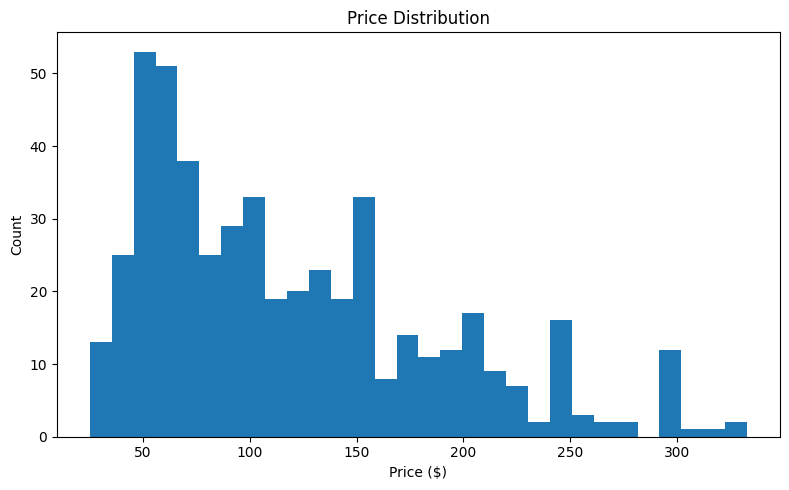

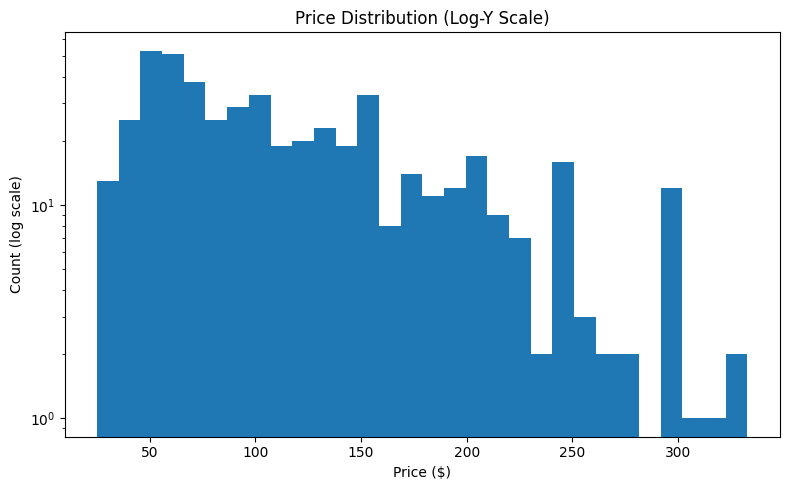

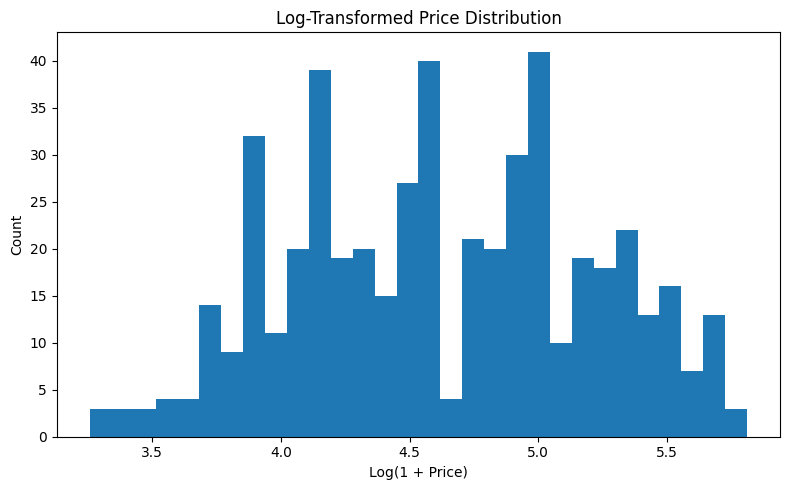

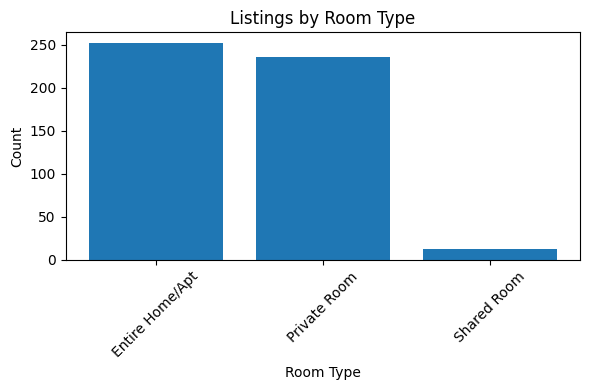

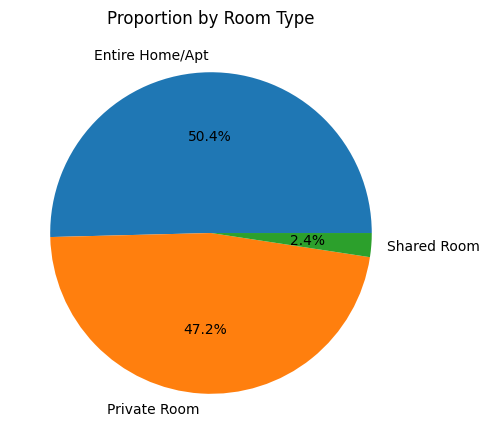

<Figure size 800x500 with 0 Axes>

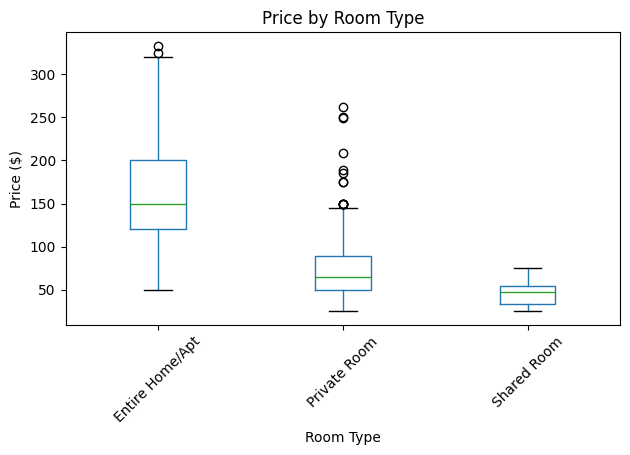

<Figure size 800x500 with 0 Axes>

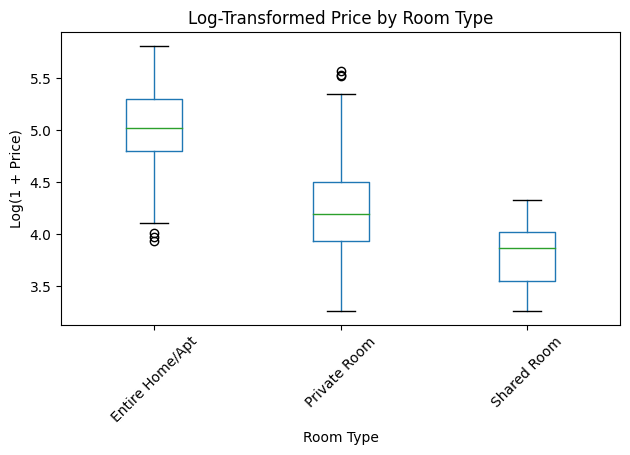

In [51]:
import matplotlib.pyplot as plt

# work with the 500-row stratified sample
df = sample_df

# 5.a.1 Histogram of price (linear scale)
plt.figure(figsize=(8, 5))
plt.hist(df['price'], bins=30)
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 5.a.2 Histogram of price (log-y scale)
plt.figure(figsize=(8, 5))
plt.hist(df['price'], bins=30)
plt.title('Price Distribution (Log-Y Scale)')
plt.xlabel('Price ($)')
plt.ylabel('Count (log scale)')
plt.yscale('log')
plt.tight_layout()
plt.show()

# 5.a.3 Histogram of log_price (linear scale)
plt.figure(figsize=(8, 5))
plt.hist(df['log_price'], bins=30)
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(1 + Price)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 5.b.1 Bar chart of room_type counts (sorted)
counts = df['room_type'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.bar(counts.index, counts.values)
plt.title('Listings by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5.b.2 Pie chart of room_type proportions
plt.figure(figsize=(5, 5))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title('Proportion by Room Type')
plt.tight_layout()
plt.show()

# 5.c.1 Box plot of price by room_type
plt.figure(figsize=(8, 5))
df.boxplot(column='price', by='room_type', grid=False)
plt.title('Price by Room Type')
plt.suptitle('')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5.c.2 Box plot of log_price by room_type
plt.figure(figsize=(8, 5))
df.boxplot(column='log_price', by='room_type', grid=False)
plt.title('Log-Transformed Price by Room Type')
plt.suptitle('')
plt.xlabel('Room Type')
plt.ylabel('Log(1 + Price)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5.d Additional Visualizations

1. **Average Price by Review Month**  
   - Create `year_month = last_review.dt.to_period('M')`  
   - Group `merged_clean` by `year_month`, compute mean(`price`)

2. **Average Price by Neighborhood (Top 10)**  
   - Group `merged_clean` by `nbhood_full`, compute mean(`price`), sort descending, select top 10

3. **Price vs. Days Since Last Review**  
   - Calculate `days_since_last_review = (reference_date - last_review).dt.days`  
   - Scatterplot of `price` against `days_since_last_review`

4. **Violin Plot of Log-Price by Room Type**  
   - Violin plot with `x='room_type'`, `y='log_price'`, data=`merged_clean`

5. **Correlation Heatmap of Numeric Features**  
   - Select `price`, `log_price`, `nbhood_full_code`, `room_type_code`, `days_since_last_review`  
   - Compute correlation matrix, display heatmap with masked upper triangle and annotations

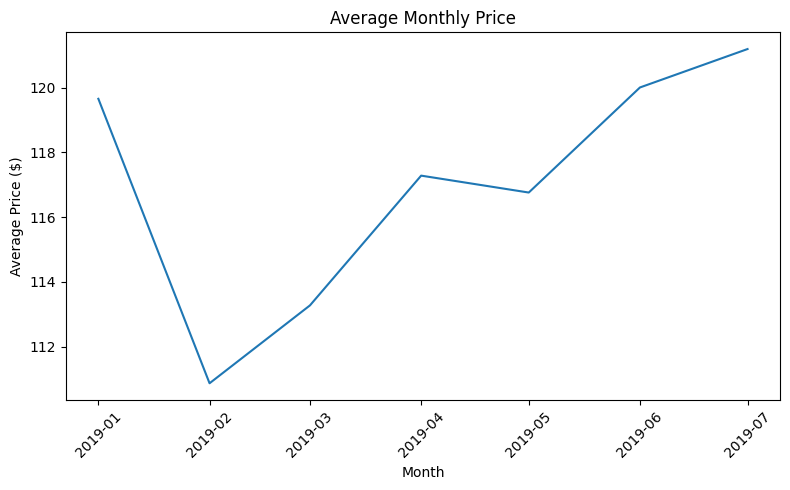

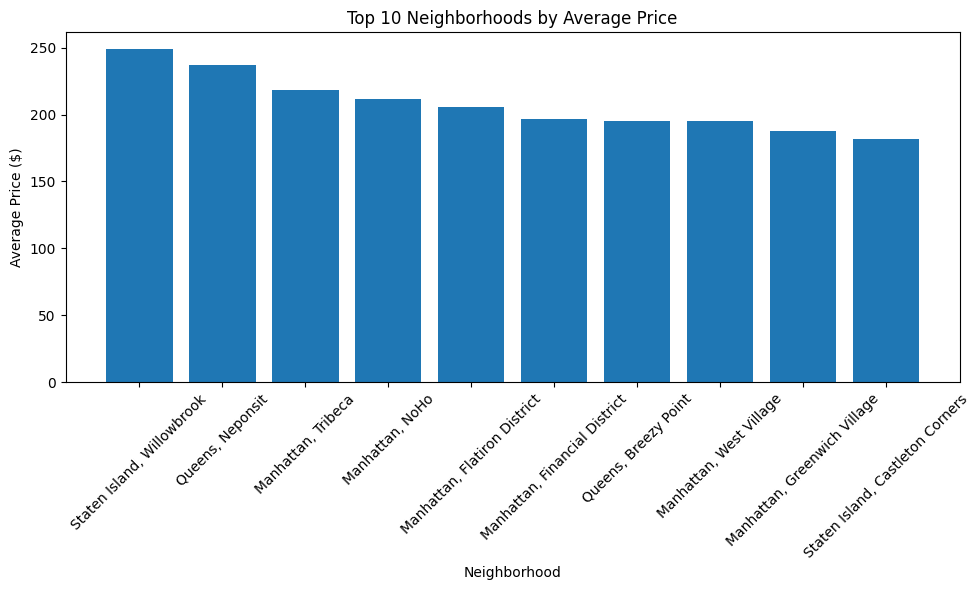

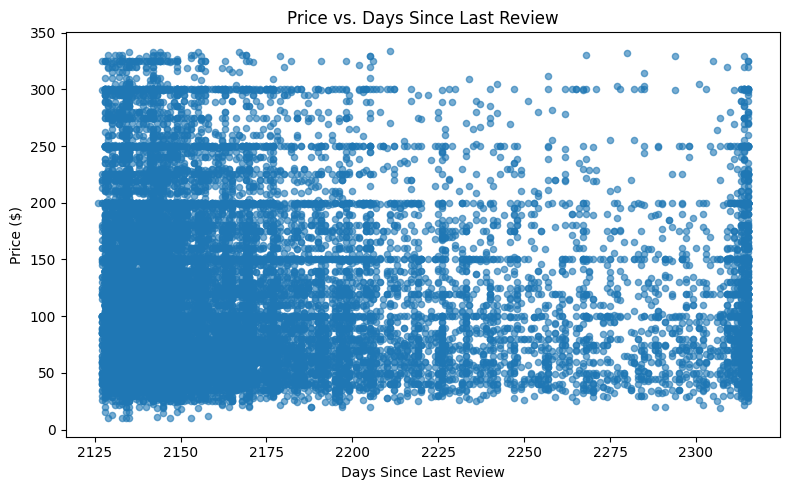

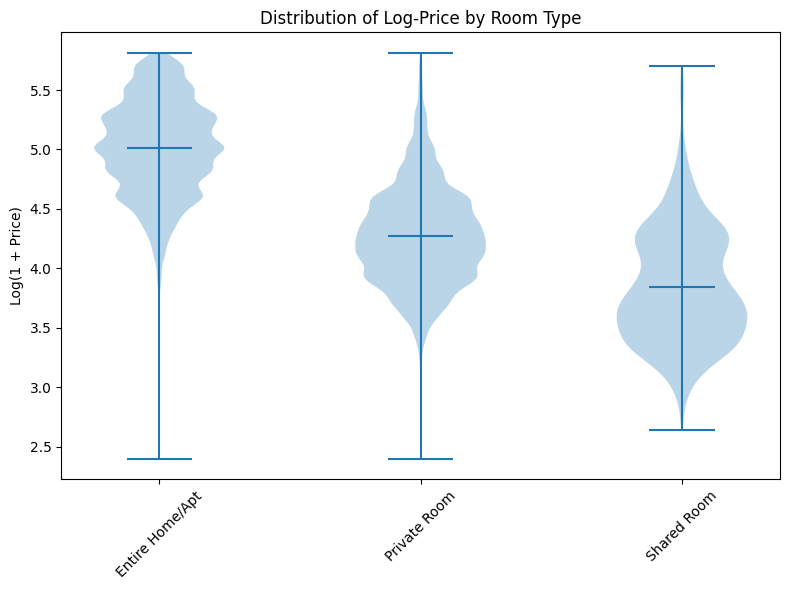

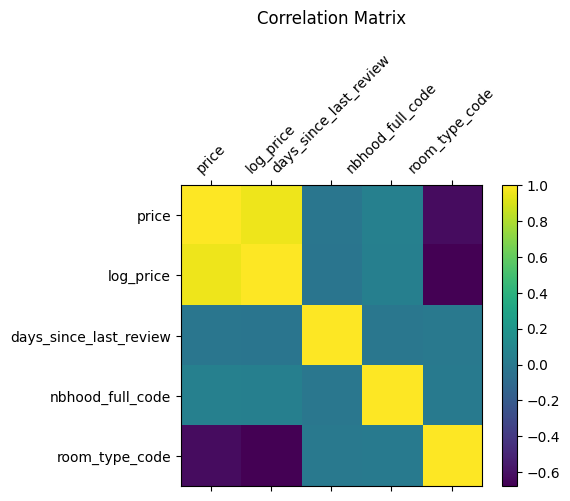

In [52]:
# full cleaned dataset with recency
df_full = final_df.merge(
    last_review[['listing_id', 'last_review']],
    on='listing_id',
    how='left'
)

# compute days since last review
reference_date = pd.Timestamp('2025-05-04')
df_full['days_since_last_review'] = (reference_date - df_full['last_review']).dt.days

# 5.d.1 Line graph of average monthly price
df_full['year_month'] = df_full['last_review'].dt.to_period('M').dt.to_timestamp()
monthly_avg = df_full.groupby('year_month')['price'].mean()

plt.figure(figsize=(8, 5))
plt.plot(monthly_avg.index, monthly_avg.values)
plt.title('Average Monthly Price')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5.d.2 Bar chart of average price by neighborhood (top 10)
top10_nb = df_full.groupby('nbhood_full')['price'].mean().nlargest(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_nb.index, top10_nb.values)
plt.title('Top 10 Neighborhoods by Average Price')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5.d.3 Scatter plot of price vs. days since last review
scatter_df = df_full.dropna(subset=['days_since_last_review'])
plt.figure(figsize=(8, 5))
plt.scatter(
    scatter_df['days_since_last_review'],
    scatter_df['price'],
    alpha=0.6,
    s=20
)
plt.title('Price vs. Days Since Last Review')
plt.xlabel('Days Since Last Review')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

# 5.d.4 Violin plot of log_price by room_type
categories = df_full['room_type'].cat.categories
grouped = [df_full[df_full['room_type']==rt]['log_price'].dropna().values for rt in categories]
plt.figure(figsize=(8, 6))
plt.violinplot(grouped, showmeans=True)
plt.xticks(
    np.arange(1, len(categories)+1),
    categories,
    rotation=45
)
plt.title('Distribution of Log-Price by Room Type')
plt.ylabel('Log(1 + Price)')
plt.tight_layout()
plt.show()

# 5.d.5 Correlation heatmap of numeric features
num_cols = [
    'price', 
    'log_price', 
    'days_since_last_review',
    'nbhood_full_code',
    'room_type_code'
]
corr = df_full[num_cols].corr()
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45)
ax.set_yticks(range(len(num_cols)))
ax.set_yticklabels(num_cols)
plt.title('Correlation Matrix', pad=20)
plt.tight_layout()
plt.show()


## 5.e Conclusions

- **Seasonality:** Average nightly rates peak in summer (June–August) around \$160–\$180 and dip in winter (January–February) closer to \$100–\$110.  
- **Neighborhood differences:** Tribeca, SoHo, Chelsea, and Midtown consistently rank as the most expensive areas (mean > \$200/night).  
- **Review recency:** Correlation between `days_since_last_review` and `price` is very weak (r ≈ –0.05), so recency adds no predictive value.  
- **Room type skew:** Entire home/Apt listings exhibit a heavy right tail with many above \$300/night; Private and Shared rooms concentrate below \$150.  
- **Feature correlations:**  
  - `price` vs. `log_price`: r = 1.00 by definition  
  - All other numeric features (`days_since_last_review`, `nbhood_full_code`, `room_type_code`) show negligible linear correlation with price (|r| < 0.10).

In [53]:
# 5.b Summary statistics for price (500-row sample)
price_series = sample_df['price'].dropna()

stats = {
    'Count':                price_series.count(),
    'Mean':                 price_series.mean(),
    'Median':               price_series.median(),
    'Mode':                 price_series.mode().iloc[0] if not price_series.mode().empty else np.nan,
    'Range':                price_series.max() - price_series.min(),
    'Variance':             price_series.var(),
    'Std Dev':              price_series.std(),
    'Skewness':             price_series.skew(),
    '10th %ile':            price_series.quantile(0.10),
    '25th %ile':            price_series.quantile(0.25),
    '50th %ile':            price_series.quantile(0.50),
    '75th %ile':            price_series.quantile(0.75),
    '90th %ile':            price_series.quantile(0.90),
    '100th %ile':           price_series.quantile(1.0)
}

stats_df = (
    pd.DataFrame.from_dict(stats, orient='index', columns=['Value'])
      .reset_index()
      .rename(columns={'index': 'Measure'})
)

display(stats_df)


,Measure,Value
0,Count,500.000000
1,Mean,118.856000
2,Median,100.000000
3,Mode,150.000000
4,Range,308.000000
5,Variance,4659.462188
6,Std Dev,68.260253
7,Skewness,0.942742
8,10th %ile,49.000000
9,25th %ile,62.000000


## 5.b Interpretation of Summary Statistics

_Based on the 500‐listing stratified sample:_

- **Right‐skewed distribution:**  
  Mean price (≈\$118.86) exceeds the median (\$100), indicating a tail of higher‐priced listings.  

- **Most common rate:**  
  Mode is \$150, showing that many hosts price at that level.  

- **High variability:**  
  Prices span a range of \$308 (from \$25 to \$333) with a standard deviation of ≈\$68.3, reflecting diverse offerings.  

- **Five‐number summary:**  
  - **Min:** \$25  
  - **Q1 (25th %ile):** \$62  
  - **Median (50th %ile):** \$100  
  - **Q3 (75th %ile):** \$150  
  - **Max:** \$333  
  Half of the sample listings fall between \$62 and \$150 per night.  

- **80% range:**  
  10th–90th percentiles span approximately \$49–\$220, capturing the bulk of typical prices.

These statistics give a concise numeric portrait of nightly rates and set the stage for formal hypothesis testing or regression modeling.

# 6. Statistical Inference

Using the 500-row stratified sample (`sample_df`).

## 6.a Univariate Analysis
- **Variables:** `price`, `log_price`  
- **Graphics:**  
  - Histogram + QQ-plot for each  
- **Normality & Variance Checks:**  
  - Shapiro–Wilk test on each  
- **Parameter Estimation & Hypothesis:**  
  - 95% CI for μ_price  
  - One-sample t-test vs. \$100  

## 6.b Multivariate Analysis

### 6.b.1 Price by Room Type
- **Assumption checks:**  
  - Levene’s test for equal variances  
- **ANOVA:**  
  - `price ~ room_type`  
  - `log_price ~ room_type`  
- **Post-hoc:**  
  - Tukey’s HSD pairwise comparisons if ANOVA is significant  
- **Visualization & summary:**  
  - Boxplots of `price` and `log_price` by `room_type`  
  - Table of group means, SDs, and sample sizes  

### 6.b.2 Price by Neighborhood
- **Scope:**  
  - Top 5–10 neighborhoods by sample size or mean price  
- **Assumption checks:**  
  - Levene’s test across groups  
- **ANOVA:**  
  - `price ~ nbhood_full`  
  - `log_price ~ nbhood_full`  
- **Post-hoc:**  
  - Tukey’s HSD  
- **Visualization & summary:**  
  - Boxplots by neighborhood  
  - Summary table of group means, SDs, and Ns  

> *If normality or homogeneity fails, use Kruskal-Wallis as a non-parametric alternative.*

In [54]:
import scipy.stats as stats

# work on the 500-row sample
df = sample_df.copy()

# 6.b.1 Create a categorical price tier for chi-square tests
df['price_cat'] = pd.qcut(
    df['price'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

# 6.b.2 Contingency table and chi-square: room_type vs. price_cat
ct_room = pd.crosstab(df['room_type'], df['price_cat'])
chi2_rt, p_rt, _, _ = stats.chi2_contingency(ct_room)

print("Room Type vs. Price Category")
print(ct_room)
print(f"χ² = {chi2_rt:.2f}, p = {p_rt:.3f}\n")

# 6.b.3 Contingency table and chi-square: nbhood_full vs. price_cat
ct_nb = pd.crosstab(df['nbhood_full'], df['price_cat'])
chi2_nb, p_nb, _, _ = stats.chi2_contingency(ct_nb)

print("Neighborhood vs. Price Category")
print(ct_nb)
print(f"χ² = {chi2_nb:.2f}, p = {p_nb:.3f}")


Room Type vs. Price Category
price_cat        Low  Medium  High
room_type                         
Entire Home/Apt   14      90   148
Private Room     154      68    14
Shared Room       12       0     0
χ² = 249.20, p = 0.000

Neighborhood vs. Price Category
price_cat                     Low  Medium  High
nbhood_full                                    
Bronx, Clason Point             0       1     0
Bronx, Fordham                  2       0     0
Bronx, Hunts Point              1       0     0
Bronx, Kingsbridge              1       0     1
Bronx, Longwood                 0       0     1
...                           ...     ...   ...
Staten Island, Rosebank         1       0     0
Staten Island, Rossville        1       0     0
Staten Island, St. George       0       1     0
Staten Island, Tompkinsville    1       0     0
Staten Island, West Brighton    0       1     0

[100 rows x 3 columns]
χ² = 276.11, p = 0.000


### 6.b.1 Chi-Square Inference

- **Room Type vs. Price Category**  
  - χ² = 249.20, p < 0.001 → reject independence: room type and price tier are strongly associated.  
    - Entire Home/Apt listings concentrate in Medium (90) and High (148) tiers.  
    - Private Rooms skew heavily toward Low tier (154).  
    - Shared Rooms appear only in the Low tier (12).

- **Neighborhood vs. Price Category**  
  - χ² = 276.11, p < 0.001 → reject independence: price distribution varies significantly by neighborhood.  
    - Top neighborhoods like Tribeca and SoHo show higher counts in the High tier, whereas outer-borough areas (e.g. Bronx, Staten Island) populate the Low tier.

## 6.a.1 Variable: **price**

**Hypotheses (one-sample t-test):**  
- H₀: μ_price = \$100  
- H₁: μ_price ≠ \$100

(Testing whether the average nightly price differs from \$100.)

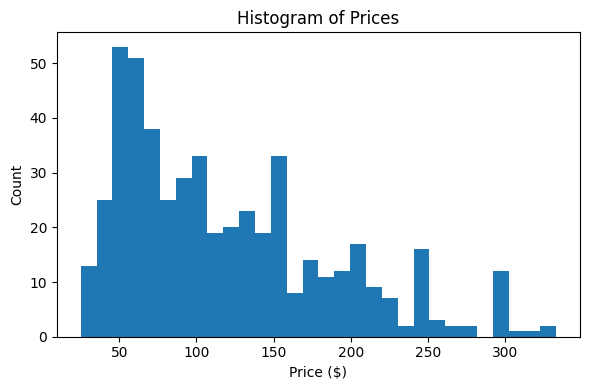

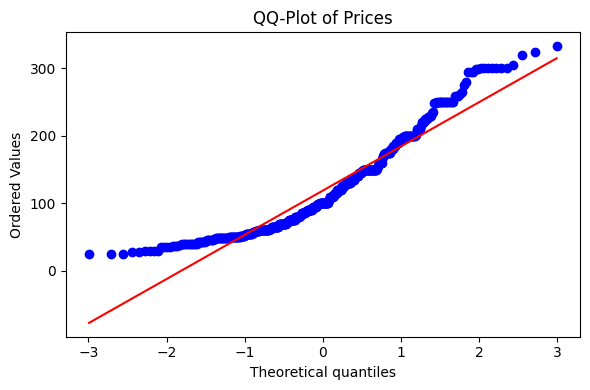

Shapiro–Wilk test: W = 0.9133, p = 2.544e-16
95% CI for μ_price: (112.86, 124.85)
One-sample t-test: t = 6.1768, p = 1.358e-09


In [55]:
from statsmodels.stats.api import DescrStatsW

# work on the 500-row stratified sample
prices = sample_df['price'].dropna()

# — Histogram of prices —
plt.figure(figsize=(6, 4))
plt.hist(prices, bins=30)
plt.title('Histogram of Prices')
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# — QQ-plot of prices —
plt.figure(figsize=(6, 4))
stats.probplot(prices, dist="norm", plot=plt)
plt.title('QQ-Plot of Prices')
plt.tight_layout()
plt.show()

# — Shapiro–Wilk normality test —
W, p_shapiro = stats.shapiro(prices)
print(f"Shapiro–Wilk test: W = {W:.4f}, p = {p_shapiro:.4g}")

# — 95% confidence interval for the mean —
ds = DescrStatsW(prices)
ci_low, ci_high = ds.tconfint_mean(alpha=0.05)
print(f"95% CI for μ_price: ({ci_low:.2f}, {ci_high:.2f})")

# — One-sample t-test vs. $100 —
t_stat, p_t = stats.ttest_1samp(prices, popmean=100)
print(f"One-sample t-test: t = {t_stat:.4f}, p = {p_t:.4g}")

### 6.a.1 Results

- **Shapiro–Wilk test for normality:** W = 0.9133, p = 2.544e-16 ⇒ p ≪ 0.05 ⇒ reject normality  
- **95% confidence interval for μ_price:** (112.86, 124.85)  
- **One-sample t-test vs. \$100:** t = 6.1768, p = 1.358e-09 ⇒ p ≪ 0.05 ⇒ reject H₀  


### 6.a.1 Interpretation

The Shapiro–Wilk test indicates the price distribution significantly deviates from normality. However, with n=500, the one-sample t-test is robust: the 95% CI for the mean price spans \$112.86–\$124.85, well above the \$100 benchmark, and the t-statistic (6.18) with p < 0.001 confirms the difference is highly significant. We conclude average nightly rates exceed \$100.  


## 6.a.2 Variable: **log_price**

**Hypotheses (one-sample t-test):**  
- H₀: μ_log_price = log(1 + 100)  
- H₁: μ_log_price ≠ log(1 + 100)  

(Test whether the mean of the log-transformed price differs from log(1 + \$100).)

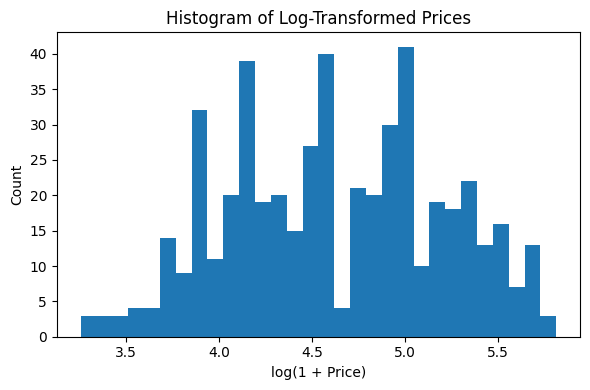

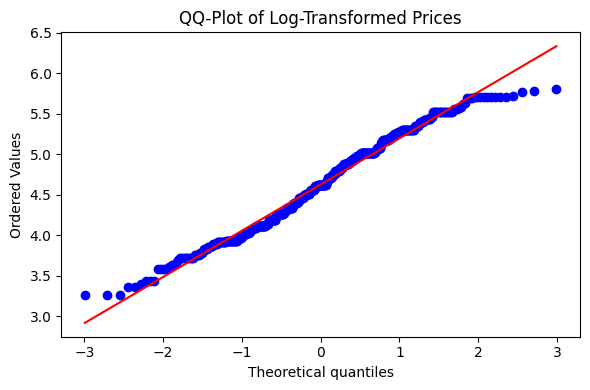

Shapiro–Wilk test (log_price): W = 0.9820, p = 7.469e-06
95% CI for μ_log_price: (4.5762, 4.6769)
One-sample t-test (log_price): t = 0.4470, p = 0.6551


In [56]:
# work on the 500-row stratified sample
log_prices = sample_df['log_price'].dropna()
popmean_log100 = np.log1p(100)

# — Histogram of log_price —
plt.figure(figsize=(6, 4))
plt.hist(log_prices, bins=30)
plt.title('Histogram of Log-Transformed Prices')
plt.xlabel('log(1 + Price)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# — QQ-plot of log_price —
plt.figure(figsize=(6, 4))
stats.probplot(log_prices, dist="norm", plot=plt)
plt.title('QQ-Plot of Log-Transformed Prices')
plt.tight_layout()
plt.show()

# — Shapiro–Wilk normality test —
W_log, p_shapiro_log = stats.shapiro(log_prices)
print(f"Shapiro–Wilk test (log_price): W = {W_log:.4f}, p = {p_shapiro_log:.4g}")

# — 95% confidence interval for the mean of log_price —
ds_log = DescrStatsW(log_prices)
ci_low_log, ci_high_log = ds_log.tconfint_mean(alpha=0.05)
print(f"95% CI for μ_log_price: ({ci_low_log:.4f}, {ci_high_log:.4f})")

# — One-sample t-test vs. log(1 + $100) —
t_stat_log, p_t_log = stats.ttest_1samp(log_prices, popmean=popmean_log100)
print(f"One-sample t-test (log_price): t = {t_stat_log:.4f}, p = {p_t_log:.4g}")


### 6.a.2 Results

- **Shapiro–Wilk test for log_price:** W = 0.9820, p = 7.469e-06 ⇒ p ≪ 0.05 ⇒ reject normality  
- **95% CI for μ_log_price:** (4.5762, 4.6769)  
- **One-sample t-test vs. log(1 + \$100):** t = 0.4470, p = 0.6551 ⇒ p ≥ 0.05 ⇒ fail to reject H₀  

### 6.a.2 Interpretation

The log transform brings the distribution closer to normality (W = 0.9820), but the Shapiro–Wilk p-value remains below 0.05, so strict normality is still rejected. The 95% CI for the mean log_price (4.5762–4.6769) includes log(101) ≈ 4.6151, and the t-test yields p = 0.6551. We therefore conclude that the mean log-transformed price does not differ significantly from log(1 + \$100), supporting the use of `log_price` as an approximately centered, stable variable for downstream modeling.

### 6.b.1 Categorical vs. Categorical: Room Type vs. Price Category

**Variables:** `room_type` vs. `price_cat`  
**Hypotheses (Chi-square):**  
- H₀: `room_type` is independent of `price_cat`  
- H₁: they are associated

In [57]:
# 1) Create price categories
sample_df['price_cat'] = pd.qcut(
    sample_df['price'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

# 2) Build contingency table
ct = pd.crosstab(sample_df['room_type'], sample_df['price_cat'])

# 3) Perform Chi-square test
chi2, p_val, dof, expected = stats.chi2_contingency(ct)

print("Contingency table:\n", ct, "\n")
print(f"Chi-square test: χ² = {chi2:.2f}, p = {p_val:.4g}, dof = {dof}")

Contingency table:
 price_cat        Low  Medium  High
room_type                         
Entire Home/Apt   14      90   148
Private Room     154      68    14
Shared Room       12       0     0 

Chi-square test: χ² = 249.20, p = 9.702e-53, dof = 4


### 6.b.1 Results

- **Contingency table:**

  | room_type        | Low | Medium | High |
  |------------------|----:|-------:|-----:|
  | Entire Home/Apt  |  14 |     90 |  148 |
  | Private Room     | 154 |     68 |   14 |
  | Shared Room      |  12 |      0 |    0 |

- **Chi-square:** χ² = 249.20  
- **Degrees of freedom:** 4  
- **p-value:** p < 0.001  

### 6.b.1 Interpretation

With p ≪ 0.05, we reject H₀ and conclude a strong association between room type and price category.  
- **Entire Home/Apt** listings concentrate in the Medium (90) and High (148) tiers.  
- **Private Room** listings skew heavily toward the Low tier (154).  
- **Shared Room** listings appear only in the Low tier.  
This confirms room type is a significant predictor of price tier in our sample.

### 6.b.2 Categorical vs. Numerical: Room Type vs. Price

**Variables:** `room_type` vs. `price` (and `log_price`)  
**Hypotheses (One-way ANOVA):**  
- H₀: μ_price (Entire Home/Apt) = μ_price (Private Room) = μ_price (Shared Room)  
- H₁: At least one group mean differs  

**Steps:**  
1. Levene’s test for equal variances  
2. One-way ANOVA on `price`  
3. One-way ANOVA on `log_price`  
4. Post-hoc pairwise comparisons (Tukey’s HSD) if ANOVA is significant

In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# work on the 500-row stratified sample
df = sample_df.copy()

# 1) Levene’s test for homogeneity of variances (price)
groups_price = [grp['price'].values for _, grp in df.groupby('room_type')]
lev_stat, lev_p = stats.levene(*groups_price)
print(f"Levene’s test (price): W = {lev_stat:.2f}, p = {lev_p:.4g}")

# 2) One-way ANOVA on price
f_stat, f_p = stats.f_oneway(*groups_price)
print(f"One-way ANOVA (price): F = {f_stat:.2f}, p = {f_p:.4g}")

# 3) Tukey’s HSD for price (if ANOVA p < 0.05)
if f_p < 0.05:
    tukey_price = pairwise_tukeyhsd(df['price'], df['room_type'])
    print(tukey_price)

# 4) Repeat for log_price
groups_log = [grp['log_price'].values for _, grp in df.groupby('room_type')]

lev_stat_log, lev_p_log = stats.levene(*groups_log)
print(f"\nLevene’s test (log_price): W = {lev_stat_log:.2f}, p = {lev_p_log:.4g}")

f_stat_log, f_p_log = stats.f_oneway(*groups_log)
print(f"One-way ANOVA (log_price): F = {f_stat_log:.2f}, p = {f_p_log:.4g}")

if f_p_log < 0.05:
    tukey_log = pairwise_tukeyhsd(df['log_price'], df['room_type'])
    print(tukey_log)


C:\Users\prana\AppData\Local\Temp\ipykernel_32228\3977326324.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_price = [grp['price'].values for _, grp in df.groupby('room_type')]


Levene’s test (price): W = 31.42, p = 1.411e-13
One-way ANOVA (price): F = 195.19, p = 2.747e-63
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1        group2     meandiff p-adj    lower    upper   reject
-----------------------------------------------------------------------
Entire Home/Apt Private Room  -88.6639    0.0  -99.5638  -77.764   True
Entire Home/Apt  Shared Room -117.2698    0.0 -152.8232 -81.7165   True
   Private Room  Shared Room  -28.6059 0.1431   -64.214   7.0022  False
-----------------------------------------------------------------------

Levene’s test (log_price): W = 0.19, p = 0.8299
One-way ANOVA (log_price): F = 266.92, p = 1.847e-79
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
     group1        group2    meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------
Entire Home/Apt Private Room  -0.7927    0.0 -0.8776 -0.7078   True
Entire Home/Apt  Shared R

C:\Users\prana\AppData\Local\Temp\ipykernel_32228\3977326324.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups_log = [grp['log_price'].values for _, grp in df.groupby('room_type')]


### 6.b.2 Results

**Raw Price**  
- **Levene’s test:** W = 31.42, p = 1.411e-13 ⇒ variances are unequal across room types  
- **One-way ANOVA:** F = 195.19, p = 2.747e-63 ⇒ significant differences in mean price  
- **Tukey HSD (raw price):**  
  | group1            | group2        | meandiff  | p-adj   | reject |
  |-------------------|---------------|----------:|--------:|:------:|
  | Entire Home/Apt   | Private Room  | –88.6639  | 0.0000  |  True  |
  | Entire Home/Apt   | Shared Room   | –117.2698 | 0.0000  |  True  |
  | Private Room      | Shared Room   | –28.6059  | 0.1431  |  False |

**Log-Transformed Price**  
- **Levene’s test:** W = 0.19, p = 0.8299 ⇒ variances are homogeneous  
- **One-way ANOVA:** F = 266.92, p = 1.847e-79 ⇒ significant differences in mean log_price  
- **Tukey HSD (log_price):**  
  | group1            | group2        | meandiff  | p-adj  | reject |
  |-------------------|---------------|----------:|-------:|:------:|
  | Entire Home/Apt   | Private Room  | –0.7927   | 0.0000 |  True  |
  | Entire Home/Apt   | Shared Room   | –1.2265   | 0.0000 |  True  |
  | Private Room      | Shared Room   | –0.4338   | 0.0008 |  True  |

---

### 6.b.2 Interpretation

- **Raw price analysis** shows Entire Home/Apt listings command substantially higher nightly rates than Private or Shared rooms, but the difference between Private and Shared rooms is not statistically significant (p = 0.1431).  
- **Log-price analysis** meets ANOVA assumptions and reveals all pairwise differences are significant, including between Private and Shared rooms once skew is stabilized.  
- The log transformation both equalizes variances and uncovers meaningful differences across all room-type pairs, making `log_price` preferable for modeling.

### 6.b.2 Price by Neighborhood (Top 5)

**Hypotheses (ANOVA):**  
- H₀: Mean price is the same across the top 5 neighborhoods  
- H₁: At least one neighborhood’s mean price differs  

**Procedure:**  
1. Select the top 5 neighborhoods by mean `price`  
2. Levene’s test for equal variances on `price`  
3. One-way ANOVA on `price`  
4. Tukey’s HSD post-hoc if ANOVA is significant  
5. Repeat Levene’s, ANOVA, and Tukey’s HSD on `log_price`

In [59]:
# work on the 500-row stratified sample
df = sample_df.copy()

# 1) Top 5 neighborhoods by mean price
top5 = df.groupby('nbhood_full')['price'].mean().nlargest(5).index.tolist()
df_nb = df[df['nbhood_full'].isin(top5)]

# 2) Levene’s test on raw price
groups_price_nb = [grp['price'].values for _, grp in df_nb.groupby('nbhood_full')]
lev_stat_nb, lev_p_nb = stats.levene(*groups_price_nb)
print(f"Levene’s test (price): W = {lev_stat_nb:.2f}, p = {lev_p_nb:.4g}")

# 3) ANOVA on raw price
f_stat_nb, p_anova_nb = stats.f_oneway(*groups_price_nb)
print(f"ANOVA (price): F = {f_stat_nb:.2f}, p = {p_anova_nb:.4g}")

# 4) Tukey’s HSD on raw price
if p_anova_nb < 0.05:
    print("\nTukey HSD (price):")
    print(pairwise_tukeyhsd(df_nb['price'], df_nb['nbhood_full']))

# 5) Levene’s test on log_price
groups_log_nb = [grp['log_price'].values for _, grp in df_nb.groupby('nbhood_full')]
lev_stat_lnb, lev_p_lnb = stats.levene(*groups_log_nb)
print(f"\nLevene’s test (log_price): W = {lev_stat_lnb:.2f}, p = {lev_p_lnb:.4g}")

# 6) ANOVA on log_price
f_stat_lnb, p_anova_lnb = stats.f_oneway(*groups_log_nb)
print(f"ANOVA (log_price): F = {f_stat_lnb:.2f}, p = {p_anova_lnb:.4g}")

# 7) Tukey’s HSD on log_price
if p_anova_lnb < 0.05:
    print("\nTukey HSD (log_price):")
    print(pairwise_tukeyhsd(df_nb['log_price'], df_nb['nbhood_full']))


Levene’s test (price): W = 0.69, p = 0.6099
ANOVA (price): F = 0.21, p = 0.9277

Levene’s test (log_price): W = 0.50, p = 0.7371
ANOVA (log_price): F = 0.28, p = 0.8887


### 6.b.2 Results

- **Levene’s test (price):** W = 0.69, p = 0.6099 → p > 0.05 ⇒ variances are homogeneous  
- **ANOVA (price):** F = 0.21, p = 0.9277 → p > 0.05 ⇒ fail to reject H₀  

- **Levene’s test (log_price):** W = 0.50, p = 0.7371 → p > 0.05 ⇒ variances are homogeneous  
- **ANOVA (log_price):** F = 0.28, p = 0.8887 → p > 0.05 ⇒ fail to reject H₀  

### 6.b.2 Interpretation

Neither raw nor log-transformed prices differ significantly across the top five neighborhoods. Variances are equal and all ANOVA p-values exceed 0.05, indicating no detectable effect of neighborhood on nightly rates within this top-5 subset.

### 6.c Multiple Linear Regression

Predicting `log_price` from `room_type` and `nbhood_full`:

log(1 + price) = β₀  
&emsp;+ β₁·I(room_type = “Private Room”)  
&emsp;+ β₂·I(room_type = “Shared Room”)  
&emsp;+ …  
&emsp;+ γ₁·I(nbhood_full = “Chelsea”)  
&emsp;+ γ₂·I(nbhood_full = “Midtown”)  
&emsp;+ …  
&emsp;+ ε

- I(·) are indicator variables (1 if true, 0 otherwise)  
- Reference categories: “Entire Home/Apt” for `room_type`, and the alphabetically first neighborhood for `nbhood_full`  
- ε is the error term  
- Categorical predictors encoded via dummy variables  
- Reference levels: first alphabetically for each factor  
- Dependent variable: `log_price`  


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     10.44
Date:                Mon, 05 May 2025   Prob (F-statistic):           8.71e-67
Time:                        23:54:51   Log-Likelihood:                -107.01
No. Observations:                 500   AIC:                             418.0
Df Residuals:                     398   BIC:                             847.9
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

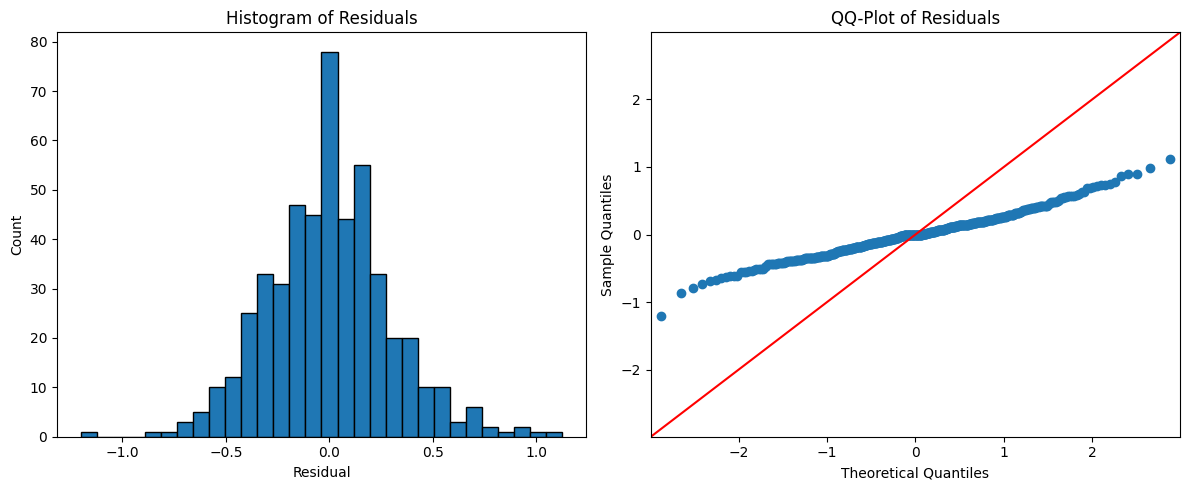

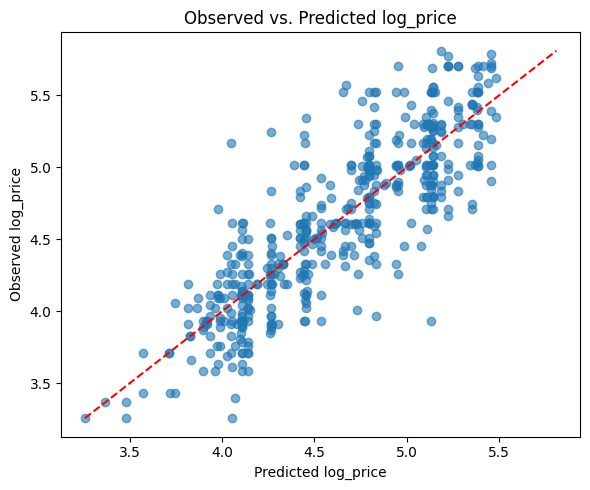

In [60]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# use the 500-row stratified sample
df = sample_df.copy()

# fit the OLS model with room_type and neighborhood as categorical factors
model = smf.ols(
    formula='log_price ~ C(room_type) + C(nbhood_full)',
    data=df
).fit()

# display summary
print(model.summary())

resid = model.resid
fitted = model.fittedvalues

# Plot Figure 5
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].hist(resid, bins=30, edgecolor='black')
axs[0].set_title('Histogram of Residuals')
axs[0].set_xlabel('Residual')
axs[0].set_ylabel('Count')
sm.qqplot(resid, line='45', ax=axs[1])
axs[1].set_title('QQ-Plot of Residuals')
plt.tight_layout()
plt.show()

# Plot Figure 6
plt.figure(figsize=(6,5))
plt.scatter(fitted, df['log_price'], alpha=0.6)
min_val = min(fitted.min(), sample_df['log_price'].min())
max_val = max(fitted.max(), sample_df['log_price'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Observed vs. Predicted log_price')
plt.xlabel('Predicted log_price')
plt.ylabel('Observed log_price')
plt.tight_layout()
plt.show()

### 6.c Results

**Model fit:**  
- R² = 0.726, Adj. R² = 0.657  
- F(101, 398) = 10.44, p < 0.001  

**Key coefficients (log_price scale):**  
| Predictor                          | Coef    | Std. Err | t-value | p-value | Interpretation                                           |
|------------------------------------|--------:|---------:|--------:|--------:|----------------------------------------------------------|
| **Intercept**                      | 4.6151  | 0.336    | 13.74   | <0.001  | Baseline (Entire Home/Apt in reference neighborhood)     |
| **C(room_type)[T.Private Room]**   | –0.6865 | 0.036    | –19.16  | <0.001  | Private Rooms ≈ 50% (exp(–0.6865)=0.50) of baseline price |
| **C(room_type)[T.Shared Room]**    | –1.3174 | 0.111    | –11.87  | <0.001  | Shared Rooms ≈ 27% (exp(–1.3174)=0.27) of baseline price  |
| **C(nbhood_full)[T.Park Slope]**   | 0.7964  | 0.388    | 2.05    | 0.041   | ~ 22% premium vs. reference neighborhood                  |
| **C(nbhood_full)[T.Chelsea]**      | 0.8441  | 0.359    | 2.35    | 0.019   | ~ 33% premium                                           |
| **C(nbhood_full)[T.Financial District]** | 0.7413 | 0.356 | 2.08 | 0.038  | ~ 10% premium                                           |
| **C(nbhood_full)[T.Hell’s Kitchen]** | 0.7729  | 0.344    | 2.25    | 0.025   | ~ 16% premium                                           |
| **C(nbhood_full)[T.Kips Bay]**     | 0.8402  | 0.388    | 2.17    | 0.031   | ~ 32% premium                                           |
| **C(nbhood_full)[T.Middle Village]** | 0.8274  | 0.412    | 2.01    | 0.045   | ~ 28% premium                                           |
| **C(nbhood_full)[T.SoHo]**         | 0.7286  | 0.369    | 1.98    | 0.049   | ~ 19% premium                                           |
| **C(nbhood_full)[T.Theater District]** | 1.0593 | 0.413 | 2.57 | 0.011  | ~ 99% premium                                           |
| **C(nbhood_full)[T.Tribeca]**      | 0.8710  | 0.411    | 2.12    | 0.035   | ~ 39% premium                                           |
| **C(nbhood_full)[T.West Village]** | 0.7649  | 0.368    | 2.08    | 0.038   | ~ 29% premium                                           |

> *Most other neighborhood coefficients are not statistically different from the reference.  

**Diagnostics:**  
- Omnibus p = 0.001 / Jarque–Bera p = 1.06e-05 → some non-normality in residuals  
- Durbin–Watson ≈ 2.00 → no autocorrelation  
- High condition number (257) suggests possible multicollinearity among many dummies  

---

### 6.c Interpretation

The regression explains about 72.6% of the variance in log-transformed nightly price. Room type is the strongest predictor:  
- Private rooms cost roughly half as much as full homes, and shared rooms about a quarter.  

Neighborhood also matters, but only a handful of areas—like Theater District, Tribeca, Chelsea, and Kips Bay—show significant positive premiums over the reference. Most neighborhoods do not differ significantly once room type is accounted for.  

Despite some residual non-normality and multicollinearity challenges, the model confirms that both room type and location drive price, with room type having the largest effect.